<a href="https://colab.research.google.com/github/XiaoxueRan/hku_phys3151_2022/blob/main/Assignment_4_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random generation of configurations

In [2]:
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame

with open('allconf.csv', mode='w') as res_file:
  res_writer = csv.writer(res_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  m =[100,100,100,100,100,98,96,92,78,52,36,28,22,20,18,16]
  i = 0
  a = 0
  nu = 42    # the number of up spins, change this to get configurations under a specific M
  while i < 5000:
    conf = np.zeros((100))
    #a = random.sample(range(0, 99), nu)
    a = np.random.randint(0,99,nu)
    b = np.random.randint(0,2)
    if b == 0:
      conf[:] = 1
      for j in range(nu):
        conf[a[j]] = 0
    else:
      conf[:] = 0
      for j in range(nu):
        conf[a[j]] = 1
    #print(sum(conf))
    res_writer.writerow(conf)
    i += 1

In [3]:
import pandas as pd
df = pd.read_csv("allconf.csv",header=None)
df = df.to_numpy()
x = df
print(x.shape)

(5000, 100)


In [4]:
np.random.seed(0) # fixing the random seed
idx = np.arange(len(x))

tval = np.hstack([t]*5000 for t in np.arange(0.25,4.01,0.25)) # Temperature values for each sample
print(tval)
rand = np.random.choice(idx, size=5000, replace=False)
x1 = x[rand]
tval = tval[rand]
print(x1.shape)
#print(rand)

np.savetxt("/content/conf.csv", x1, delimiter=",")
np.savetxt("/content/temp.csv", tval, delimiter=",")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


[0.25 0.25 0.25 ... 4.   4.   4.  ]
(5000, 100)


# Monte Carlo simulation of 2D Ising model

The following code simulates the Ising model in 2D using the Metropolis algorithm. The main steps of Metropolis algorithm are:

1. Prepare an initial configuration of N spins
2. Flip the spin of a randomly chosen lattice site. 
3. Calculate the change in energy dE. 
4. If dE < 0, accept the move. Otherwise accept the move with probability exp^{-dE/T}. This satisfies the detailed balance condition, ensuring a final equilibrium state. 
5. Repeat 2-4.

In the code below, we have estimated and plotted energy, magnetization, specific heat and susceptibility of the system.

In [5]:
## import standard libraries for scientific computations

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye

In [6]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------



def initialstate(N):   
    ''' 
    Generates a random spin configuration for initial condition
    '''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state



def mcmove(config, beta):
    '''
    Monte Carlo move using Metropolis algorithm 
    '''
    
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config



def calcEnergy(config):
    '''
    Energy of a given configuration
    '''
    energy = 0 
    
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/2.  # to compensate for over-counting



def calcMag(config):
    '''
    Magnetization of a given configuration
    '''
    mag = np.sum(config)
    mag = abs(mag)
    return mag

In [7]:
#----------------------------------------------------------------------
## NOTE: change these parameters for a smaller and faster simulation 
#----------------------------------------------------------------------


nt      = 21          #  number of temperature points
N       = 10          #  size of the lattice, N x N
eqSteps = 5000        #  number of MC sweeps for equilibration
mcSteps = 5000       #  number of MC sweeps for calculation
nbin = 1


T       = np.linspace(0.25,4.25, nt); 
E,M,C,X = np.zeros((nt,nbin)), np.zeros((nt,nbin)), np.zeros((nt,nbin)), np.zeros((nt,nbin))
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

In [8]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
import csv

for tt in range(nt):
    config = initialstate(N)         # initialise

    E1 = M1 = E2 = M2 = 0
    iT=1.0/T[tt]; iT2=iT*iT;
    #iT=T[tt];iT2=iT+0.25;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for k in range(nbin):
      E1=0;E2=0;M1=0;M2=0
      for i in range(mcSteps):
        mcmove(config, iT)

        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene 


    # divide by number of sites and iteractions to obtain intensive values    
      E[tt,k] = n1*E1
      M[tt,k] = n1*M1
      C[tt,k] = (n1*E2 - n2*E1*E1)*iT2
      X[tt,k] = (n1*M2 - n2*M1*M1)*iT

In [9]:
# calculate the error bar
def average(nr,dat):
  av0=sum(dat[:])/nr
  av1=sum(dat[:]**2)/nr
  av2=np.sqrt(abs(av1-av0**2)/nr)
  return av0,av2

In [17]:
ener = []; eener = [];m=[];em=[];c=[];ec=[];xx=[];exx=[]
for tt in range(nt): 
    av0,av2 = average(nbin,E[tt,:])
    ener.append(av0)
    eener.append(av2)

    av0,av2 = average(nbin,M[tt,:])
    m.append(av0)
    em.append(av2)

    av0,av2 = average(nbin,C[tt,:])
    c.append(av0)
    ec.append(av2)

    av0,av2 = average(nbin,X[tt,:])
    xx.append(av0)
    exx.append(av2)
    #print(E.shape)


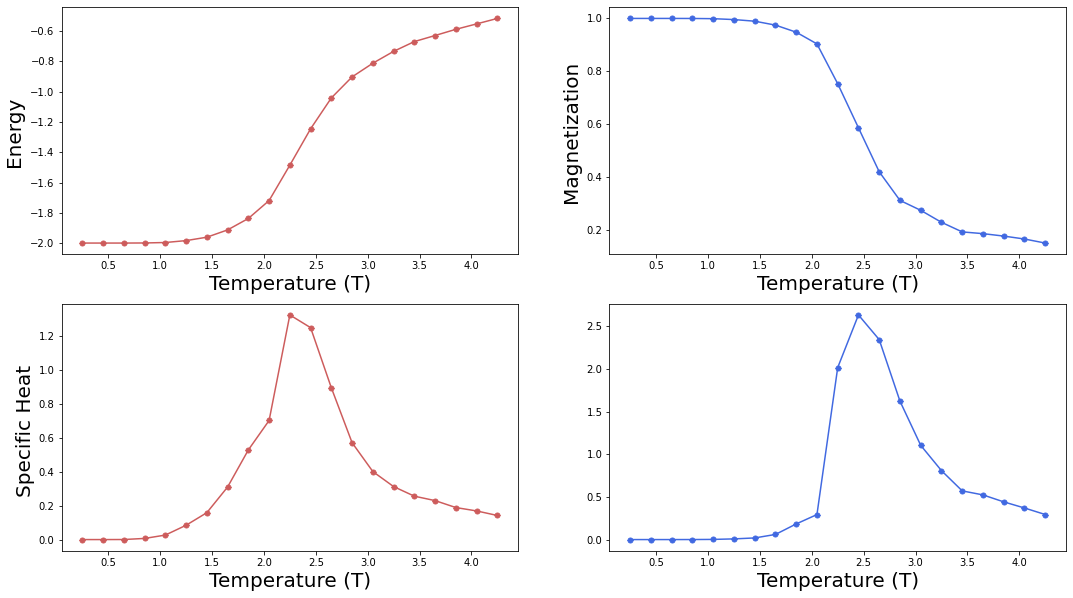

In [19]:
#----------------------------------------------------------------------
#  plot the calculated values   
#----------------------------------------------------------------------

f = plt.figure(figsize=(18, 10)); #  


sp =  f.add_subplot(2, 2, 1 );
plt.errorbar(T, ener,eener, marker='o', color='IndianRed',capsize=3,ms=5)
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(2, 2, 2 );
m=np.abs(m)
plt.errorbar(T, m,em,capsize=3,ms=5, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(2, 2, 3 );
plt.errorbar(T, c, ec,capsize=3,ms=5, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   


sp =  f.add_subplot(2, 2, 4 );
plt.errorbar(T, xx,exx,capsize=3,ms=5, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 